In [2]:
import numpy as np
import torch
from torch import nn
import random
import matplotlib.pyplot as plt
from scipy.optimize import dual_annealing
from utils import GradientBandit

In [3]:
class ConstantReward:
    def __init__(self,arms):
        reward = np.random.rand(arms)
        reward /= np.sum(reward)
        self.reward = reward

    def get_reward(self,context):
        return self.reward

In [4]:
class ModelReward:
    def __init__(self,arms,dim,noise=0.01):
        self.theta = np.random.rand(arms,dim)
        self.noise_scale = noise

    def get_reward(self,action,context):
        true_reward = action @ self.theta @ context
        return true_reward + (np.random.rand(1)-0.5) * 2*self.noise_scale

    def get_reward_torch(self,action,context):
        true_reward = action @ self.theta @ context
        return true_reward + (torch.rand(1)-0.5) * 2*self.noise_scale

In [5]:
class StrategicAgents:
    def __init__(self, dim, delta_radius, reward):
        self.delta_radius = delta_radius
        self.reward = reward
        self.dim = dim

    def generate_context(self, policy, priv):
        reward = self.reward.get_reward(priv)
        bounds = [(-self.delta_radius, self.delta_radius)] * (self.dim)
        def objective(delta):
            if np.linalg.norm(delta) > self.delta_radius:
                return np.inf
            #x_prime = np.append((priv+delta),[1])
            x_prime = priv+delta
            return -reward[np.argmax(policy@x_prime)]

        opt_delt = dual_annealing(objective, bounds)
        burden = np.linalg.norm(opt_delt.x)
        x_prime = priv + opt_delt.x

        if np.argmax(policy@x_prime) == np.argmax(policy@priv):
            x_prime = priv
            burden = 0

        return x_prime, burden
        #return x_prime, reward[np.argmax(policy@np.append(x_prime,[1]))]


In [6]:
class ImperfectStrategicAgents:
    def __init__(self, dim, delta_radius, reward, policy_noise):
        self.delta_radius = delta_radius
        self.reward = reward
        self.dim = dim
        self.policy_noise = policy_noise

    def generate_context(self, policy, priv):
        imp_policy = policy + self.policy_noise*(np.random.random(policy.shape)-0.5)
        reward = self.reward.get_reward(priv)
        bounds = [(-self.delta_radius, self.delta_radius)] * (self.dim)
        def objective(delta):
            if np.linalg.norm(delta) > self.delta_radius:
                return np.inf
            #x_prime = np.append((priv+delta),[1])
            x_prime = priv+delta
            return -reward[np.argmax(imp_policy@x_prime)]

        opt_delt = dual_annealing(objective, bounds)
        burden = np.linalg.norm(opt_delt.x)
        x_prime = priv + opt_delt.x

        if np.argmax(imp_policy@x_prime) == np.argmax(imp_policy@priv):
            x_prime = priv
            burden = 0

        return x_prime, burden
        #return x_prime, reward[np.argmax(policy@np.append(x_prime,[1]))]


In [7]:
class NonStrategicAgents:
    def __init__(self,  dim, delta_radius, reward):
        self.delta_radius = delta_radius
        self.reward = reward
        self.dim = dim

    def generate_context(self, policy, priv):
        reward = self.reward.get_reward(priv)

        return priv, 0
        #return priv, reward[np.argmax(policy@np.append(priv,[1]))]


In [8]:
class StrategyUnawareModel:
    def __init__(self,T,est_reward,lr,dim,delta_radius,arms,reward_func):
        self.delta_radius = delta_radius
        self.t = 0
        self.T = T
        self.est_agent_reward = est_reward
        self.dim = dim
        self.policy= np.random.rand(arms,dim)
        self.reward_function = reward_func
        self.committed = False
        self.arms = arms
        rewards = [ [] for i in range(self.arms)]
        contexts = [ [] for i in range(self.arms)]
        for arm in range(arms):
            rewards[arm] = []
            contexts[arm] = []
        
        self.reward_data = rewards
        self.context_data = contexts

    def refresh_policy(self):
        self.policy= np.random.rand(self.arms,self.dim)        

    def get_policy(self):
        return self.policy

    def committ(self):
        theta = np.zeros((self.arms,self.dim))
        for arm in range(self.arms):
            xs = np.asarray(self.context_data[arm])
            ys = np.asarray(self.reward_data[arm])
            
            est_theta = np.linalg.lstsq(xs,ys,rcond=None)[0]
            theta[arm,:] = est_theta.flatten()

        self.policy = theta

    def different_(self, x_true, x_observed):
        est_agent_rew = self.est_agent_reward.get_reward(None)
        y_true = self.policy@x_true
        y_obv = self.policy@x_observed
        if np.argmax(y_obv) != np.argmax(y_true):
            better = est_agent_rew[np.argmax(y_obv)] > est_agent_rew[np.argmax(y_true)]
            return True, better
        else:
            return False, False

    def get_action(self,context):
        pol = self.policy
        expected_rewards = self.policy@context
        action = np.argmax(expected_rewards)
        
        return action

    def observe_reward(self, action, context):
        est_agent_rew = self.est_agent_reward.get_reward(context)

        action_vector = np.zeros(self.arms)
        action_vector[action] += 1
        reward = self.reward_function.get_reward(action_vector,context)

        self.reward_data[action] += [reward]
        self.context_data[action] += [context]

        return reward, action

In [18]:
class SAM:
    # Strategy Aware Model
    def __init__(self,T,est_reward,lr,dim,delta_radius,arms,reward_func):
        self.delta_radius = delta_radius
        self.t = 0
        self.T = T
        self.est_agent_reward = est_reward
        self.dim = dim
        self.policy= np.random.rand(arms,dim)
        self.reward_function = reward_func
        self.committed = False
        self.arms = arms
        self.model = GradientBandit(arms,dim,bias=False)
        self.opt = torch.optim.SGD(self.model.parameters(), lr=lr, momentum=0.9)
        self.criterion = torch.nn.L1Loss()
        
        rewards = [ [] for i in range(self.arms)]
        contexts = [ [] for i in range(self.arms)]
        for arm in range(arms):
            rewards[arm] = []
            contexts[arm] = []
        
        self.reward_data = rewards
        self.context_data = contexts

    def refresh_policy(self):
        self.policy= np.random.rand(self.arms,self.dim)        

    def get_policy(self):
        return self.policy

    def committ(self):
        theta = np.zeros((self.arms,self.dim))
        for arm in range(self.arms):
            xs = np.asarray(self.context_data[arm])
            ys = np.asarray(self.reward_data[arm])
            
            est_theta = np.linalg.lstsq(xs,ys,rcond=None)[0]
            theta[arm,:] = est_theta.flatten()

        self.policy = theta

        self.model.classifier.weight = torch.nn.parameter.Parameter(torch.tensor(theta))

    def get_action(self,context):
        expected_rewards = self.policy@context
        action = np.argmax(expected_rewards)

        return action

    def __explore(self,action,context):
        est_agent_rew = self.est_agent_reward.get_reward(context)

        action_vector = np.zeros(self.arms)
        action_vector[action] += 1
        reward = self.reward_function.get_reward(action_vector,context)

        self.reward_data[action] += [reward]
        self.context_data[action] += [context]

        return reward, action

    def __exploit(self, action, context):
        self.opt.zero_grad()
        context = torch.tensor(context).reshape(1,-1).float()
        est_agent_rew = torch.tensor(self.est_agent_reward.get_reward(context)).float()
        y_hat = self.model.forward(context,est_agent_rew)
        reward = self.reward_function.get_reward_torch(action,context)
        loss = self.criterion(1/reward,torch.zeros(1))
        loss.backward()
        self.opt.step()
        self.policy = self.model.get_hyperplanes().numpy()
        action = int(torch.argmax(y_hat))
        return reward, action

    def observe_reward(self, action, context):
        if self.committed:
            return self.__exploit(action,context)
        else:
            return self.__explore(action,context)



In [25]:
T = 200
ARMS = 4
CONTEXT_DIM = 5
DELTA = 0.25
lr = 0.01
model_reward_noise = 0.05
imperfect_agent_policy_noise = 0.05

private_types = np.random.rand(T,CONTEXT_DIM)
agent_rewards = ConstantReward(ARMS)
model_reward_func = ModelReward(ARMS,CONTEXT_DIM,model_reward_noise)
strat_agents = StrategicAgents(CONTEXT_DIM,DELTA,agent_rewards)
imperfect_agents = ImperfectStrategicAgents(CONTEXT_DIM,DELTA,agent_rewards,imperfect_agent_policy_noise)
nostrat_agents = NonStrategicAgents(CONTEXT_DIM,DELTA,agent_rewards)
model = SAM(T,agent_rewards,lr,CONTEXT_DIM,DELTA,ARMS,model_reward_func)


strat_agent_errors = 0
impf_agent_error = 0
social_buden = 0
regret = [0]
for i in range(T):

    if i % 2 == 0:
            x, burden = nostrat_agents.generate_context(model.get_policy(), private_types[i])
    else:
        x, burden = strat_agents.generate_context(model.get_policy(), private_types[i])

    social_buden += burden
    action = model.get_action(x)
    reward = model.observe_reward(action,x)
    true_act = np.argmax(model_reward_func.theta @ private_types[i])
    regret.append(regret[-1] + (true_act != action))
    if i < T//2:
        model.refresh_policy()
    elif i == T//2:
        model.committ()

print("social burden {}".format(social_buden))
    

social burden 4.9354003000527955


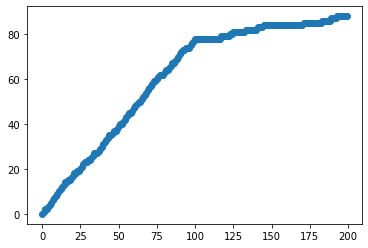

In [26]:
x = range(T)
plt.scatter(x, regret[1:])
plt.show()

In [ ]:
print(model.get_policy() - model_reward_func.theta)

[[ 0.08408272 -0.00631459 -0.03191723  0.01228912 -0.01045148]
 [-0.00943747 -0.06218272  0.02090402  0.06739823 -0.00153365]
 [-0.04761576  0.0204673  -0.0316175  -0.02749372  0.05089085]
 [-0.01039459  0.00563784  0.0088648  -0.01334329  0.00367879]]


In [28]:
xs = [0.1*x for x in range(10)]
reg_list = []
burden_list = []
for power in xs:
    T = 200
    ARMS = 4
    CONTEXT_DIM = 5
    DELTA = power + 0.0001
    lr = 0.01
    model_reward_noise = 0.25
    imperfect_agent_policy_noise = 0.25

    private_types = np.random.rand(T,CONTEXT_DIM)
    agent_rewards = ConstantReward(ARMS)
    model_reward_func = ModelReward(ARMS,CONTEXT_DIM,model_reward_noise)
    strat_agents = StrategicAgents(CONTEXT_DIM,DELTA,agent_rewards)
    imperfect_agents = ImperfectStrategicAgents(CONTEXT_DIM,DELTA,agent_rewards,imperfect_agent_policy_noise)
    nostrat_agents = NonStrategicAgents(CONTEXT_DIM,DELTA,agent_rewards)
    model = SAM(T,agent_rewards,lr,CONTEXT_DIM,DELTA,ARMS,model_reward_func)


    strat_agent_errors = 0
    impf_agent_error = 0
    social_burden = 0
    regret = [0]
    for i in range(T):
        if i % 2 == 0:
            x, burden = nostrat_agents.generate_context(model.get_policy(), private_types[i])
        # elif i % 3 == 1:
        #     x, burden = imperfect_agents.generate_context(model.get_policy(), private_types[i])
        else:
            x, burden = strat_agents.generate_context(model.get_policy(), private_types[i])
        
        social_burden += burden
        action = model.get_action(x)
        reward = model.observe_reward(action,x)
        true_act = np.argmax(model_reward_func.theta @ private_types[i])
        regret.append(regret[-1] + (true_act != action))
        if i < T//2:
            model.refresh_policy()
        elif i == T//2:
            model.committ()

        # if different:
        #     if i % 3 == 1:
        #         impf_agent_error += 1
        #     else:
        #         strat_agent_errors += 1

    burden_list += [social_burden]
    reg_list += [regret[-1]]
    

c:\Users\DeanA\anaconda3\envs\pytorch\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


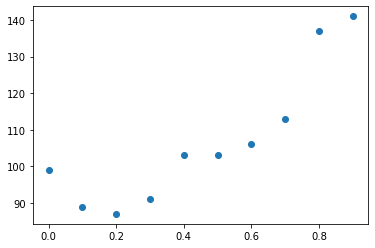

In [29]:
plt.scatter(xs, reg_list)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

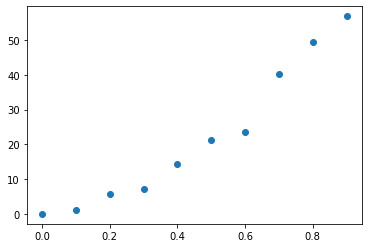

In [30]:
plt.scatter(xs,burden_list)
plt.show